# Risk-Aware Stochastic Bin Packing with Reinforcement Learning

## Project Overview
This notebook implements a **Risk-Aware Agent** for the Stochastic Bin Packing Problem (SBPP), specifically applied to airport gate assignment. The goal is to assign flights (items) to gates (bins) in a way that balances two conflicting objectives:
1.  **Efficiency**: Minimize the number of gates used.
2.  **Robustness**: Minimize the risk of "overflow" (when a flight stays longer than expected and exceeds gate capacity).

## Methodology
Instead of using a fixed safety buffer (e.g., always adding 5% extra time), we train a neural network policy to **dynamically assign padding** to each flight based on its specific characteristics:
*   **Nominal Size ($s$)**: The scheduled duration of the flight.
*   **Volatility ($\sigma$)**: The uncertainty/variance in the flight's duration.

The agent learns to add larger buffers to risky flights and smaller buffers to stable ones, optimizing the trade-off between gate usage and overflow penalties.

## Key Components
1.  **`AirportDataGen`**: Generates synthetic flight data with stochastic durations (Log-Normal distribution).
2.  **`PaddingPolicy`**: A neural network that takes flight features ($s, \sigma$) and outputs a padding value.
3.  **`worker_simulate_episode`**: A CPU-intensive worker function that runs the Best-Fit Decreasing (BFD) heuristic and calculates the actual overflow.
4.  **`train_agent`**: The main training loop using **REINFORCE (Policy Gradient)** with a baseline to optimize the policy. It uses **Multiprocessing** to parallelize the simulation of episodes.
5.  **Evaluation**: Compares the trained AI agent against naive and fixed-padding strategies.

## Implementation

### Imports & Setup

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Progress bar for loops
import multiprocessing # For parallel simulation
import time

# Import core logic from external file (core.py)
# This includes the simulation worker, BFD, and data generator
from core import worker_simulate_episode, bfd, AirportDataGen

# Auto-reload external modules to reflect changes in core.py immediately
%load_ext autoreload
%autoreload 2

# Set random seeds for reproducibility
tf.random.set_seed(111652004)
np.random.seed(111652004)

# Configure plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

### Neural Network Policy

In [2]:
class PaddingPolicy(tf.keras.Model):
    """
    A simple Feed-Forward Neural Network (MLP) that acts as the agent's policy.
    
    Input:
        - Flight features: [nominal_size, volatility]
    
    Output:
        - Padding amount: A value between 0.0 and 0.2 (scaled sigmoid).
          This represents the safety buffer added to the flight's scheduled duration.
    """
    def __init__(self):
        super(PaddingPolicy, self).__init__()
        # Two hidden layers with 32 neurons each and ReLU activation
        self.d1 = tf.keras.layers.Dense(32, activation='relu')
        self.d2 = tf.keras.layers.Dense(32, activation='relu')
        # Output layer with sigmoid activation to bound the output between 0 and 1
        self.out = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.d1(inputs)
        x = self.d2(x)
        # Scale the output to be at most 0.2 (20% of capacity)
        return self.out(x) * 0.2 

def gaussian_log_prob(x, mu, sigma):
    """
    Calculates the log-probability of an action `x` sampled from a Normal distribution N(mu, sigma).
    Used for the REINFORCE algorithm to compute policy gradients.
    """
    return -0.5 * np.log(2 * np.pi) - tf.math.log(sigma) - 0.5 * ((x - mu) / sigma)**2

### Main Training Loop

In [3]:
def train_agent(num_episodes=20000, lambda_penalty=500.0, number_of_flights=600, seed=None):
    """
    Trains the Risk-Aware Agent using Policy Gradient (REINFORCE).
    
    Args:
        num_episodes (int): Total number of episodes to train.
        lambda_penalty (float): The penalty weight for overflow. Higher = more risk-averse.
        number_of_flights (int): Number of flights (items) per episode.
        seed (int): Random seed for reproducibility.
        
    Returns:
        policy: The trained neural network.
        reward_history: List of rewards over time.
        overflow_history: List of total overflow over time.
        bins_history: List of number of bins used over time.
    """
    
    # Set random seeds if provided
    if seed is not None:
        tf.random.set_seed(seed)
        np.random.seed(seed)
    
    # --- Setup Parallel Processing ---
    num_cores = multiprocessing.cpu_count()
    # Determine batch size based on CPU cores to maximize parallel efficiency
    BATCH_SIZE = max(num_cores * 2, 64)
    
    env_gen = AirportDataGen()
    policy = PaddingPolicy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    reward_history = []
    overflow_history = []
    bins_history = []
    
    num_batches = num_episodes // BATCH_SIZE
    
    # Create a pool of workers for parallel simulation
    pool = multiprocessing.Pool(processes=num_cores)
    
    # Progress bar
    pbar = tqdm(range(num_batches), desc="Training")
    
    for batch_step in pbar:
        # --- 1. Data Generation ---
        # Generate a batch of flight data (nominal sizes and volatilities)
        s_batch, sigma_batch = env_gen.generate_batch_data(BATCH_SIZE, number_of_flights)
        
        # Prepare input tensor: Shape (Batch, Num_Flights, 2)
        state_input = np.stack([s_batch, sigma_batch], axis=2).astype(np.float32)
        state_tensor = tf.convert_to_tensor(state_input)
        
        # --- 2. Forward Pass (Policy Execution) ---
        with tf.GradientTape() as tape:
            # Get the mean padding action from the policy network
            mu_padding = policy(state_tensor)
            
            # Exploration Strategy: Linearly decay exploration noise (std_dev)
            current_episode = batch_step * BATCH_SIZE
            std_exploration = max(0.01, 0.1 * (1 - current_episode/(num_episodes * 0.8)))
            
            # Sample action from Normal distribution (Gaussian Policy)
            # Action = Mean + Noise
            action_padding = mu_padding + tf.random.normal(shape=tf.shape(mu_padding), stddev=std_exploration)
            # Clip action to be valid (non-negative, max 0.5)
            action_padding = tf.clip_by_value(action_padding, 0.0, 0.5)
            
            # --- 3. Environment Simulation (Parallelized on CPU) ---
            # Convert tensors to numpy for the worker functions
            padding_np = action_padding.numpy()
            padding_flat = padding_np.squeeze(axis=-1)
            
            # Prepare arguments for each worker
            batch_seeds = np.random.randint(0, 10000000, size=BATCH_SIZE)
            worker_args = []
            for i in range(BATCH_SIZE):
                # Each worker gets: (s, sigma, padding, capacity, penalty_weight, seed)
                worker_args.append((s_batch[i], sigma_batch[i], padding_flat[i], 1.0, lambda_penalty, batch_seeds[i]))
            
            # Execute simulations in parallel!
            # This runs the BFD heuristic and calculates realized overflow
            results = pool.map(worker_simulate_episode, worker_args)
            
            # Process results
            results = np.array(results) 
            batch_bins = results[:, 0]      # Number of bins used
            batch_overflow = results[:, 1]  # Total overflow duration
            
            # --- 4. Loss Calculation (Policy Gradient) ---
            t_bins = tf.convert_to_tensor(batch_bins, dtype=tf.float32)
            t_overflow = tf.convert_to_tensor(batch_overflow, dtype=tf.float32)
            
            # Reward Function: Negative of (Bins + Penalty * Overflow)
            # We normalize by number of flights to keep the scale consistent
            loss_vals = t_bins + (lambda_penalty * t_overflow)
            rewards = -loss_vals / number_of_flights
            
            # Calculate Advantage (Reward - Baseline)
            # Baseline is the mean reward of the current batch (reduces variance)
            baseline = tf.reduce_mean(rewards)
            advantage = rewards - baseline
            
            # Compute Log Probabilities of the taken actions
            log_probs = gaussian_log_prob(action_padding, mu_padding, std_exploration)
            # Sum log probs over all flights in an episode
            episode_log_probs = tf.reduce_sum(log_probs, axis=[1, 2])
            
            # Policy Gradient Loss: -mean(log_prob * advantage)
            policy_loss = -tf.reduce_mean(episode_log_probs * advantage)
            
        # --- 5. Backpropagation (Update Weights) ---
        grads = tape.gradient(policy_loss, policy.trainable_variables)
        # Clip gradients to prevent explosion
        grads, _ = tf.clip_by_global_norm(grads, 1.0)
        optimizer.apply_gradients(zip(grads, policy.trainable_variables))
        
        # --- 6. Logging ---
        reward_history.extend(rewards.numpy().tolist())
        overflow_history.extend(batch_overflow.tolist())
        bins_history.extend(batch_bins.tolist())
        
        # Update progress bar with current average reward
        if batch_step % 10 == 0:
            avg_r = np.mean(rewards.numpy())
            pbar.set_postfix({'Reward': f'{avg_r:.4f}'})

    # Clean up multiprocessing pool
    pool.close()
    pool.join()
    
    return policy, reward_history, overflow_history, bins_history

### Experiment Runner

In [4]:
# Define hyperparameters
LAMBDA_VALUES = [75.0, 100.0, 125.0] # Different risk aversion levels to test
SEEDS = [11, 16, 52, 0, 4] # Random seeds for multi-seed training
NUM_EPISODES = 32000 # Total training episodes (high number for convergence)
NUM_FLIGHTS = 5000    # Number of flights per episode

# Dictionaries to store results
# Key: "AI (λ=X)" -> Value: List of trained policies
trained_policies = {}
training_stats = {}

# Loop through each lambda value
for lam in LAMBDA_VALUES:
    key = f"AI (λ={int(lam)})"
    trained_policies[key] = []
    training_stats[key] = [] # List of stats dicts
    
    print(f"\n" + "="*50)
    print(f"🚀 Training Agent Group with Lambda = {lam}")
    print("="*50)
    
    # Train multiple agents with different seeds
    for seed in SEEDS:
        print(f"   > Training Seed: {seed}")
        
        # Train the agent
        policy, rewards, overflows, bins = train_agent(
            num_episodes=NUM_EPISODES, 
            lambda_penalty=lam, 
            number_of_flights=NUM_FLIGHTS,
            seed=seed
        )
        
        # Store the trained policy and statistics
        trained_policies[key].append(policy)
        
        training_stats[key].append({
            "seed": seed,
            "rewards": rewards, 
            "overflows": overflows, 
            "bins": bins
        })


🚀 Training Agent Group with Lambda = 75.0
   > Training Seed: 11


Training: 100%|██████████| 500/500 [00:50<00:00,  9.83it/s, Reward=-0.2310]



   > Training Seed: 16


Training: 100%|██████████| 500/500 [00:48<00:00, 10.36it/s, Reward=-0.2254]



   > Training Seed: 52


Training: 100%|██████████| 500/500 [00:48<00:00, 10.36it/s, Reward=-0.2317]



   > Training Seed: 0


Training: 100%|██████████| 500/500 [00:48<00:00, 10.34it/s, Reward=-0.2333]



   > Training Seed: 4


Training: 100%|██████████| 500/500 [00:48<00:00, 10.31it/s, Reward=-0.2277]




🚀 Training Agent Group with Lambda = 100.0
   > Training Seed: 11


Training: 100%|██████████| 500/500 [00:48<00:00, 10.26it/s, Reward=-0.2300]



   > Training Seed: 16


Training: 100%|██████████| 500/500 [00:49<00:00, 10.20it/s, Reward=-0.2419]



   > Training Seed: 52


Training: 100%|██████████| 500/500 [00:49<00:00, 10.20it/s, Reward=-0.2308]



   > Training Seed: 0


Training: 100%|██████████| 500/500 [00:49<00:00, 10.14it/s, Reward=-0.2339]



   > Training Seed: 4


Training: 100%|██████████| 500/500 [00:48<00:00, 10.21it/s, Reward=-0.2313]




🚀 Training Agent Group with Lambda = 125.0
   > Training Seed: 11


Training: 100%|██████████| 500/500 [00:49<00:00, 10.08it/s, Reward=-0.2329]



   > Training Seed: 16


Training: 100%|██████████| 500/500 [00:49<00:00, 10.10it/s, Reward=-0.2373]



   > Training Seed: 52


Training: 100%|██████████| 500/500 [00:50<00:00, 10.00it/s, Reward=-0.2328]



   > Training Seed: 0


Training: 100%|██████████| 500/500 [00:49<00:00, 10.03it/s, Reward=-0.2384]



   > Training Seed: 4


Training: 100%|██████████| 500/500 [00:50<00:00,  9.97it/s, Reward=-0.2336]



### Evaluation Function

In [5]:
def evaluate_all_strategies_grouped(ai_policies_dict, num_tests=100, num_items=1000):
    """
    Evaluates multiple AI policies against baseline strategies on the same test set.
    Supports Multi-Seed evaluation by aggregating results from multiple policies per strategy key.
    
    Args:
        ai_policies_dict (dict): Dictionary mapping strategy names to lists of trained models.
                                 e.g., {"AI (λ=75)": [model_seed1, model_seed2, ...]}
        num_tests (int): Number of test episodes to run per seed.
        num_items (int): Number of flights per test episode.
        
    Returns:
        results (dict): Nested dictionary containing evaluation metrics.
                        Structure: results[strategy_name][metric] = [list of results per seed]
    """
    env_gen = AirportDataGen()
    
    # Define Baseline Strategies (Fixed Padding)
    strategies = {
        "Naive (0%)": 0.0,
        "Fixed (4.5%)": 0.045,
        "Fixed (5%)": 0.05,
        "Fixed (5.5%)": 0.055
    }
    
    # Initialize results structure
    # results[strategy][metric] = [seed1_data, seed2_data, seed3_data]
    results = {}
    for name in strategies: results[name] = {"bins": [], "overflow": []}
    for name in ai_policies_dict: results[name] = {"bins": [], "overflow": []}
        
    print(f"Running {num_tests} evaluation tests...")
    
    # Pre-generate a fixed test set to ensure fair comparison across all strategies
    # We use specific seeds for the test set generation
    test_set_seeds = [12345 + i for i in range(num_tests)]
    test_batches = []
    for seed in test_set_seeds:
        s, sigma = env_gen.generate_batch_data(1, num_items)
        test_batches.append((s[0], sigma[0]))
    
    capacity = 1.0
    
    # Define the number of seeds to simulate for baselines
    # Even though baselines are deterministic given the test set, we repeat the structure
    # to match the AI agents' data format (which has multiple training seeds).
    SEEDS_COUNT = 3 

    # --- A. Evaluate Baselines ---
    for name, fixed_pad in tqdm(strategies.items(), desc="Eval Baselines"):
        for _ in range(SEEDS_COUNT): # Repeat for each "seed slot"
            seed_bins = []
            seed_overflow = []
            
            for i in range(num_tests):
                s, sigma = test_batches[i]
                padding = np.full_like(s, fixed_pad)
                # Use the specific test seed for the simulation environment
                args = (s, sigma, padding, capacity, 0, test_set_seeds[i])
                n_bins, overflow = worker_simulate_episode(args)
                seed_bins.append(n_bins)
                seed_overflow.append(overflow)
            
            results[name]["bins"].append(seed_bins)
            results[name]["overflow"].append(seed_overflow)

    # --- B. Evaluate AI Strategies ---
    for name, policies in tqdm(ai_policies_dict.items(), desc="Eval AI Agents"):
        # Ensure policies is a list (handle single model case)
        if not isinstance(policies, list): policies = [policies]
        
        # Evaluate each trained model (corresponding to different training seeds)
        for policy_model in policies:
            seed_bins = []
            seed_overflow = []
            
            for i in range(num_tests):
                s, sigma = test_batches[i]
                
                # Prepare input for the neural network
                state_input = np.stack([s, sigma], axis=1).astype(np.float32)
                state_tensor = tf.convert_to_tensor(state_input[np.newaxis, :])
                
                # Get AI prediction
                pad_ai = policy_model(state_tensor).numpy().flatten()
                
                # Run simulation
                args = (s, sigma, pad_ai, capacity, 0, test_set_seeds[i])
                n_bins, overflow = worker_simulate_episode(args)
                seed_bins.append(n_bins)
                seed_overflow.append(overflow)
            
            results[name]["bins"].append(seed_bins)
            results[name]["overflow"].append(seed_overflow)
            
    return results

# Run the evaluation
num_items_eval = 5000
eval_results = evaluate_all_strategies_grouped(trained_policies, num_tests=100, num_items=num_items_eval)

Running 100 evaluation tests...


Eval AI Agents: 100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


### Visualization of Results

/var/folders/46/nbbc61zj3c99p08flw43z2xr0000gn/T/ipykernel_21407/371850314.py:86: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(


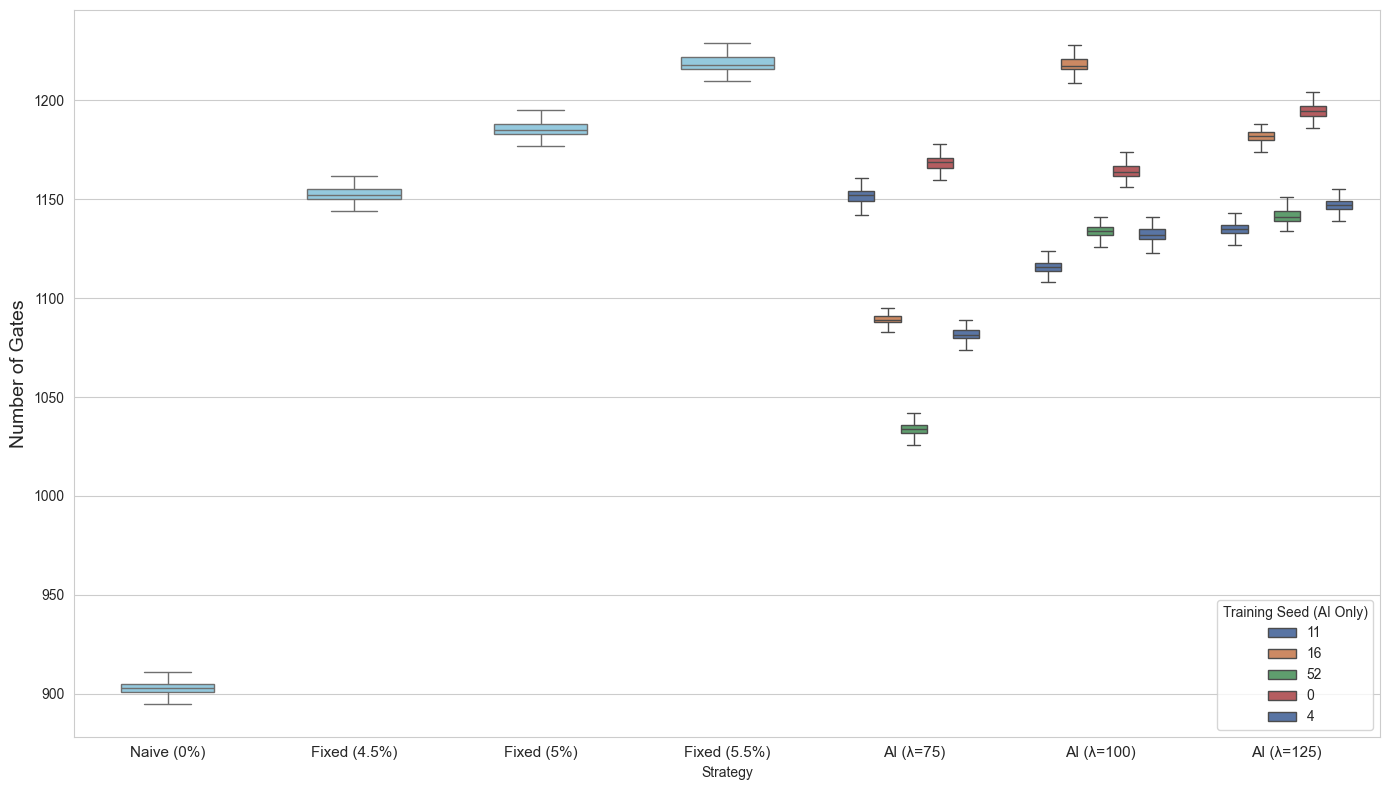

/var/folders/46/nbbc61zj3c99p08flw43z2xr0000gn/T/ipykernel_21407/371850314.py:118: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(


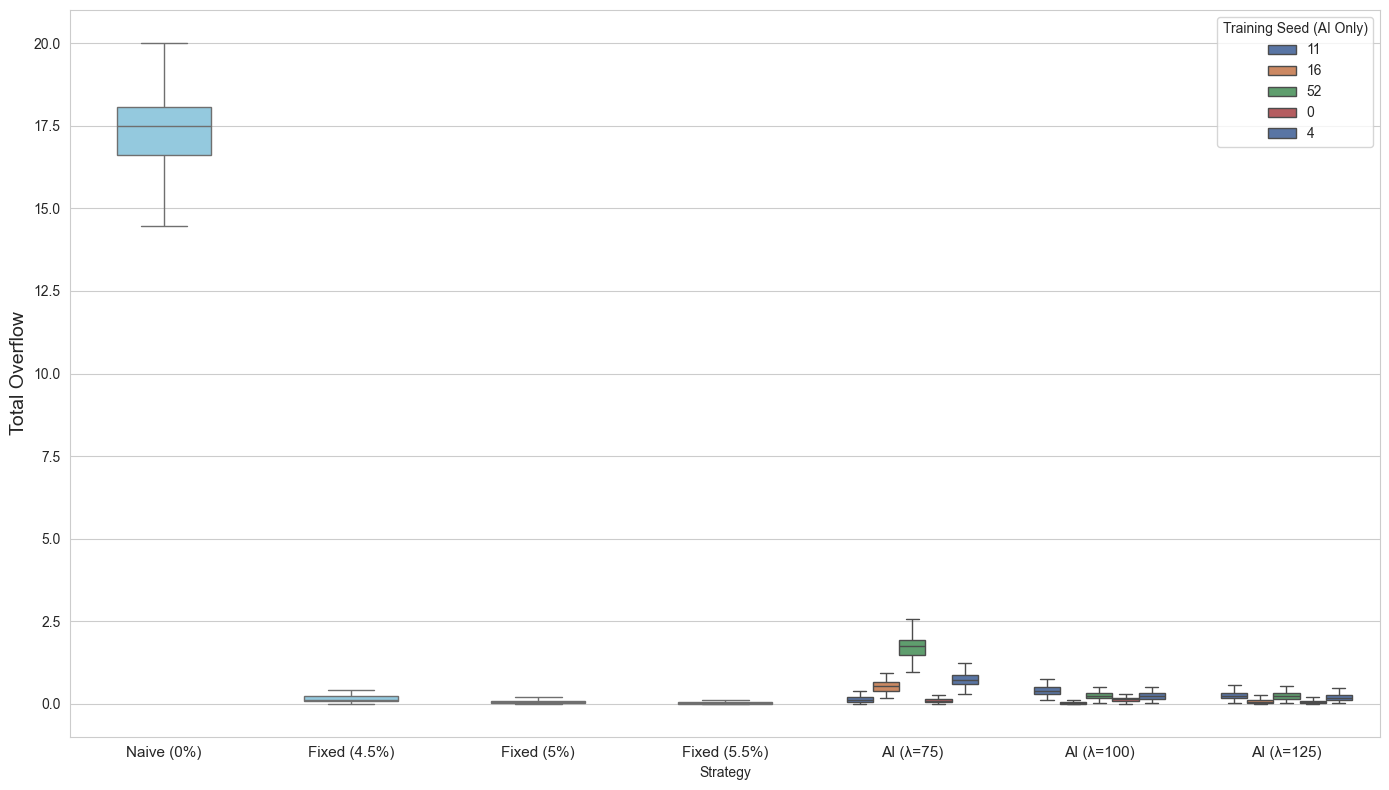

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure figures directory exists
os.makedirs('figures', exist_ok=True)

# 1. Convert results to Pandas DataFrame for Seaborn plotting
data_list = []

# Define the order of strategies for plotting
sorted_keys = [
    "Naive (0%)", 
    "Fixed (4.5%)", "Fixed (5%)", "Fixed (5.5%)",
    f"AI (λ={int(LAMBDA_VALUES[0])})",
    f"AI (λ={int(LAMBDA_VALUES[1])})",
    f"AI (λ={int(LAMBDA_VALUES[2])})"
]

fixed_strategies = ["Naive (0%)", "Fixed (4.5%)", "Fixed (5%)", "Fixed (5.5%)"]
ai_strategies = [f"AI (λ={int(lam)})" for lam in LAMBDA_VALUES]
all_strategies = fixed_strategies + ai_strategies # Fixed X-axis order

# Data containers
data_fixed_list = []
data_ai_list = []

# Define seed labels (corresponding to the training seeds used)
seed_labels = ["11", "16", "52", "0", "4"]

# --- Process Fixed Strategy Data ---
# We only take the first "seed slot" since fixed strategies are identical across slots
for strategy in fixed_strategies:
    bins_data = eval_results[strategy]["bins"][0]
    over_data = eval_results[strategy]["overflow"][0]
    
    for v_b, v_o in zip(bins_data, over_data):
        data_fixed_list.append({
            "Strategy": strategy,
            "Gates Used": v_b,
            "Total Overflow": v_o
        })

# --- Process AI Strategy Data ---
# We include data from all training seeds
for strategy in ai_strategies:
    bins_data = eval_results[strategy]["bins"]
    over_data = eval_results[strategy]["overflow"]
    
    for i in range(len(bins_data)):
        current_seed = seed_labels[i]
        for v_b, v_o in zip(bins_data[i], over_data[i]):
            data_ai_list.append({
                "Strategy": strategy,
                "Seed": current_seed,
                "Gates Used": v_b,
                "Total Overflow": v_o
            })

df_fixed = pd.DataFrame(data_fixed_list)
df_ai = pd.DataFrame(data_ai_list)

# 3. Configure Plotting Style
sns.set_style("whitegrid")

# Define Colors
ai_palette = sns.color_palette("deep", 4) 
fixed_color = "skyblue"

# ==========================================
# Figure 1: Efficiency (Gates Used)
# ==========================================
plt.figure(figsize=(14, 8))

# 1. Plot Fixed Strategies (Single box, centered)
sns.boxplot(
    data=df_fixed, x="Strategy", y="Gates Used", 
    order=all_strategies, 
    color=fixed_color, 
    width=0.5, 
    showfliers=False
)

# 2. Plot AI Strategies (Grouped boxes by Seed)
sns.boxplot(
    data=df_ai, x="Strategy", y="Gates Used", hue="Seed",
    order=all_strategies, 
    palette=ai_palette,
    width=0.7, 
    showfliers=False
)

# Formatting
plt.xticks(fontsize=11)
plt.ylabel("Number of Gates", fontsize=14)
plt.legend(title="Training Seed (AI Only)", loc='lower right')

plt.tight_layout()
plt.savefig('figures/Efficiency_Gates_Used_Hybrid_Comparison.png', transparent=True, dpi=300)
plt.show()

# ==========================================
# Figure 2: Robustness (Total Overflow)
# ==========================================
plt.figure(figsize=(14, 8))

# 1. Plot Fixed Strategies
sns.boxplot(
    data=df_fixed, x="Strategy", y="Total Overflow", 
    order=all_strategies,
    color=fixed_color, 
    width=0.5,
    showfliers=False
)

# 2. Plot AI Strategies
sns.boxplot(
    data=df_ai, x="Strategy", y="Total Overflow", hue="Seed",
    order=all_strategies,
    palette=ai_palette,
    width=0.7,
    showfliers=False
)

# Formatting
plt.xticks(fontsize=11)
plt.ylabel("Total Overflow", fontsize=14)
plt.legend(title="Training Seed (AI Only)", loc='upper right')

plt.tight_layout()
plt.savefig('figures/Robustness_Total_Overflow_Hybrid_Comparison.png', transparent=True, dpi=300)
plt.show()

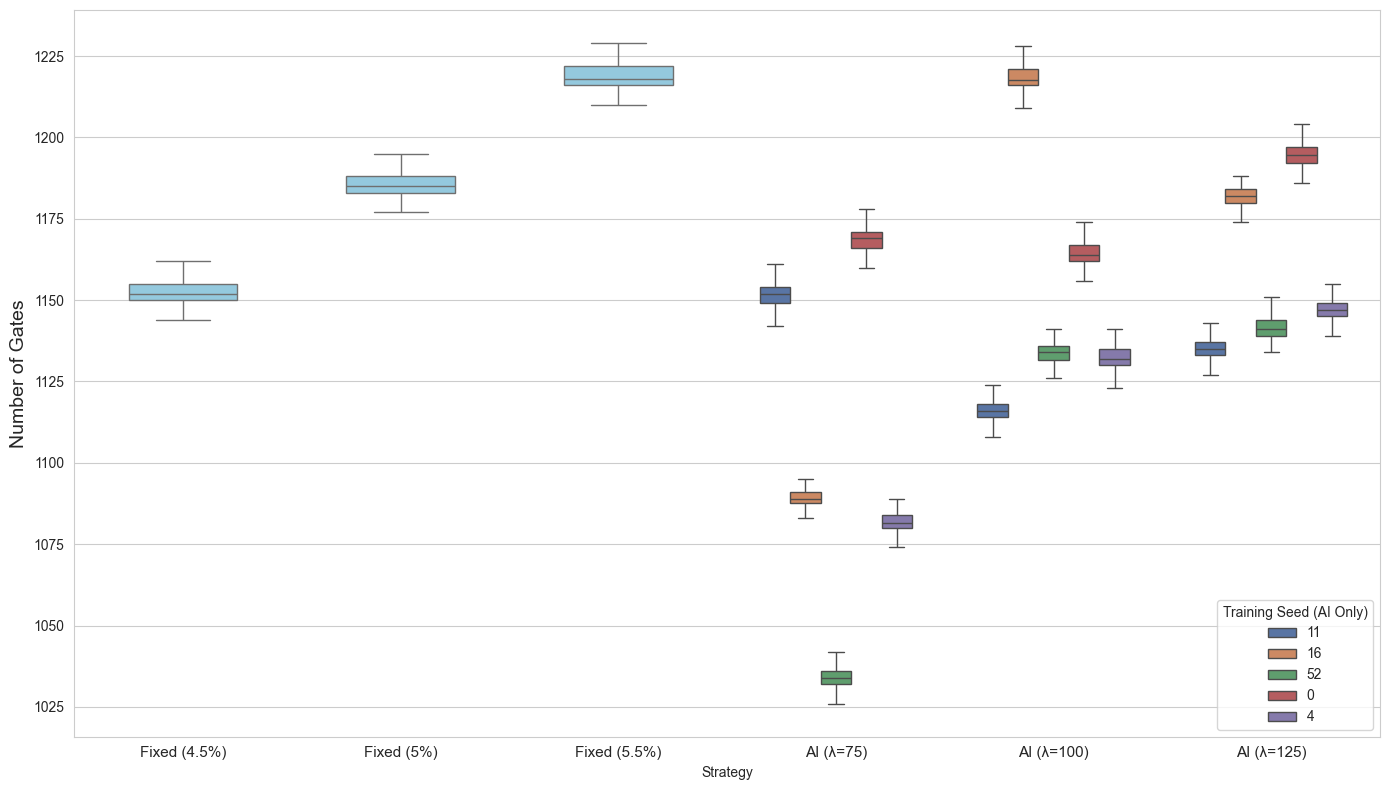

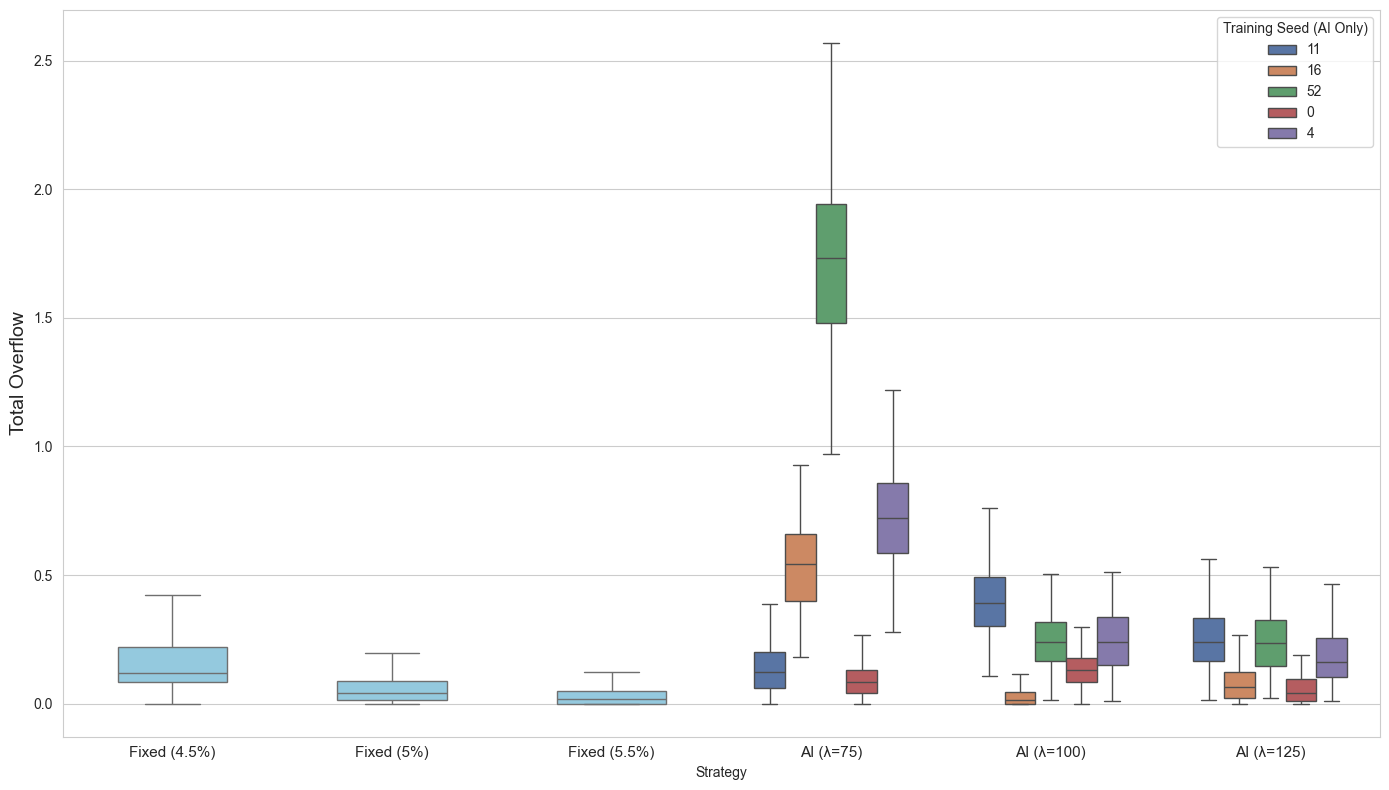

In [7]:
# Ensure figures directory exists
os.makedirs('figures', exist_ok=True)

# --- 1. Redefine Strategy List (Remove Naive) ---
# We focus on comparing AI against competitive Fixed strategies (4.5%+)
focused_fixed_strategies = ["Fixed (4.5%)", "Fixed (5%)", "Fixed (5.5%)"]

# AI strategies remain the same
ai_strategies = [f"AI (λ={int(lam)})" for lam in LAMBDA_VALUES]

# Merge for X-axis order
focused_all_strategies = focused_fixed_strategies + ai_strategies 

# --- 2. Transform Data ---
data_fixed_list = []
data_ai_list = []

# Seed labels
seed_labels = ["11", "16", "52", "0", "4"]

# --- Process Fixed Data ---
for strategy in focused_fixed_strategies:
    if strategy in eval_results:
        bins_data = eval_results[strategy]["bins"][0]
        over_data = eval_results[strategy]["overflow"][0]
        
        for v_b, v_o in zip(bins_data, over_data):
            data_fixed_list.append({
                "Strategy": strategy,
                "Gates Used": v_b,
                "Total Overflow": v_o
            })

# --- Process AI Data ---
for strategy in ai_strategies:
    if strategy in eval_results:
        bins_data = eval_results[strategy]["bins"]
        over_data = eval_results[strategy]["overflow"]
        
        for i in range(len(bins_data)):
            # Safety check for seed labels
            current_seed = seed_labels[i] if i < len(seed_labels) else str(i)
            
            for v_b, v_o in zip(bins_data[i], over_data[i]):
                data_ai_list.append({
                    "Strategy": strategy,
                    "Seed": current_seed,
                    "Gates Used": v_b,
                    "Total Overflow": v_o
                })

df_fixed = pd.DataFrame(data_fixed_list)
df_ai = pd.DataFrame(data_ai_list)

# --- 3. Plotting ---
sns.set_style("whitegrid")

# Adjust palette based on number of seeds
ai_palette = sns.color_palette("deep", len(seed_labels)) 
fixed_color = "skyblue"

# ==========================================
# Figure 1: Efficiency (Gates Used) - Focused
# ==========================================
plt.figure(figsize=(14, 8))

# 1. Plot Fixed
sns.boxplot(
    data=df_fixed, x="Strategy", y="Gates Used", 
    order=focused_all_strategies, 
    color=fixed_color, 
    width=0.5, 
    showfliers=False
)

# 2. Plot AI
sns.boxplot(
    data=df_ai, x="Strategy", y="Gates Used", hue="Seed",
    order=focused_all_strategies, 
    palette=ai_palette,
    width=0.7, 
    showfliers=False
)

plt.xticks(fontsize=11)
plt.ylabel("Number of Gates", fontsize=14)
plt.legend(title="Training Seed (AI Only)", loc='lower right')

plt.tight_layout()
plt.savefig('figures/Focused_Efficiency_Gates_Used.png', transparent=True, dpi=300)
plt.show()

# ==========================================
# Figure 2: Robustness (Total Overflow) - Focused
# ==========================================
plt.figure(figsize=(14, 8))

# 1. Plot Fixed
sns.boxplot(
    data=df_fixed, x="Strategy", y="Total Overflow", 
    order=focused_all_strategies,
    color=fixed_color, 
    width=0.5,
    showfliers=False
)

# 2. Plot AI
sns.boxplot(
    data=df_ai, x="Strategy", y="Total Overflow", hue="Seed",
    order=focused_all_strategies,
    palette=ai_palette,
    width=0.7,
    showfliers=False
)

plt.xticks(fontsize=11)
plt.ylabel("Total Overflow", fontsize=14)
plt.legend(title="Training Seed (AI Only)", loc='upper right')

plt.tight_layout()
plt.savefig('figures/Focused_Robustness_Total_Overflow.png', transparent=True, dpi=300)
plt.show()

In [8]:
def generate_stats_summary(eval_results, ai_policies_dict):
    """
    Generates a summary table of mean Efficiency (Gates) and Robustness (Overflow)
    for all strategies (excluding Naive).
    """
    
    # 1. Define Strategies to Analyze (Exclude Naive)
    strategies = ["Fixed (4.5%)", "Fixed (5%)", "Fixed (5.5%)"]
    ai_keys = [f"AI (λ={int(lam)})" for lam in LAMBDA_VALUES]
    all_keys = strategies + ai_keys
    
    summary_data = []
    
    # 2. Calculate Statistics
    for strategy in all_keys:
        if strategy not in eval_results:
            continue
            
        bins_data = eval_results[strategy]["bins"]       # List of lists (per seed)
        overflow_data = eval_results[strategy]["overflow"]
        
        # Flatten all seeds into one big list to get the global mean & std
        # (Combining all 500 tests across 5 seeds)
        all_bins = [val for sublist in bins_data for val in sublist]
        all_over = [val for sublist in overflow_data for val in sublist]
        
        # Calculate Mean & Standard Deviation
        mean_bins = np.mean(all_bins)
        std_bins = np.std(all_bins)
        
        mean_over = np.mean(all_over)
        std_over = np.std(all_over)
        
        # Determine Strategy Type
        sType = "AI Agent" if "AI" in strategy else "Fixed Baseline"
        
        summary_data.append({
            "Strategy": strategy,
            "Type": sType,
            "Avg Gates Used": mean_bins,
            "Std Gates": std_bins,
            "Avg Overflow": mean_over,
            "Std Overflow": std_over
        })
        
    # 3. Create DataFrame
    df_summary = pd.DataFrame(summary_data)
    
    # Formatting for cleaner display
    # Set precision to 2 decimal places
    pd.options.display.float_format = "{:,.2f}".format
    
    return df_summary

# Generate and Display Table
df_stats = generate_stats_summary(eval_results, trained_policies)

print("=== Performance Statistics Summary (Flight N=5000) ===")
display(df_stats)

=== Performance Statistics Summary (Flight N=5000) ===


,Strategy,Type,Avg Gates Used,Std Gates,Avg Overflow,Std Overflow
0,Fixed (4.5%),Fixed Baseline,"1,151.97",3.68,0.15,0.11
1,Fixed (5%),Fixed Baseline,"1,185.16",3.96,0.06,0.07
2,Fixed (5.5%),Fixed Baseline,"1,218.49",4.24,0.04,0.05
3,AI (λ=75),AI Agent,"1,104.92",49.22,0.65,0.63
4,AI (λ=100),AI Agent,"1,152.72",36.34,0.21,0.17
5,AI (λ=125),AI Agent,"1,159.77",24.05,0.17,0.14
